In [1]:
import pandas as pd
import numpy as np
import nltk
import string
import re
import fasttext
import contractions
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
import sys

In [2]:
tweets = pd.read_csv('covidvaccine.csv')

In [3]:
tweets.shape

(38459, 13)

In [4]:
#Checks out what type of data we're working with.

tweets.dtypes

user_name           object
user_location       object
user_description    object
user_created        object
user_followers       int64
user_friends         int64
user_favourites      int64
user_verified         bool
date                object
text                object
hashtags            object
source              object
is_retweet            bool
dtype: object

In [5]:
# Checks out what columns have null values.

for col in tweets.columns:
    print(col, tweets[col].isnull().sum())

user_name 0
user_location 8443
user_description 2373
user_created 0
user_followers 0
user_friends 0
user_favourites 0
user_verified 0
date 0
text 0
hashtags 11621
source 1
is_retweet 0


In [6]:
#Filters data, so the results have are on topic to what this analysis is looking for.

search_Keywords = ['vaccine','vaccines', 'covid-19', 'covid', 'cure','cures', 'corona','virus' 'coronavirus', '#covidvaccine','#coronavaccine'
                  '#coronavirusvaccine','#covid-19','#vaccine','#covid19vaccine']
filter_tweets_by_keywords = tweets['text'].apply(lambda x: len(set(search_Keywords) - set(x.lower().split()))) < len(search_Keywords)
tweets_filtered = tweets[filter_tweets_by_keywords].reset_index()

In [7]:
#Deletes an unnecessary column for our analysis.

del tweets_filtered['is_retweet']

In [8]:
tweets_filtered.shape

(24526, 13)

In [9]:
#Remove any contractions within the 'text' column.
#Then we recombine the elements within the 'no_contractions' column into a string.

tweets_filtered['no_contractions'] = tweets_filtered['text'].apply(lambda x: [contractions.fix(word) for word in x.split()])
tweets_filtered['text_str'] = [' '.join(map(str, l)) for l in tweets_filtered['no_contractions']]
tweets_filtered.head()

,index,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,no_contractions,text_str
0,0,MyNewsNE,Assam,MyNewsNE a dedicated multi-lingual media house...,24-05-2020 10:18,64,11,110,False,18-08-2020 12:55,Australia to Manufacture Covid-19 Vaccine and ...,['CovidVaccine'],Twitter Web App,"[Australia, to, Manufacture, Covid-19, Vaccine...",Australia to Manufacture Covid-19 Vaccine and ...
1,1,Shubham Gupta,NaN,I will tell about all experiences of my life f...,14-08-2020 16:42,1,17,0,False,18-08-2020 12:55,#CoronavirusVaccine #CoronaVaccine #CovidVacci...,"['CoronavirusVaccine', 'CoronaVaccine', 'Covid...",Twitter for Android,"[#CoronavirusVaccine, #CoronaVaccine, #CovidVa...",#CoronavirusVaccine #CoronaVaccine #CovidVacci...
2,2,Journal of Infectiology,NaN,Journal of Infectiology (ISSN 2689-9981) is ac...,14-12-2017 07:07,143,566,8,False,18-08-2020 12:46,Deaths due to COVID-19 in Affected Countries\n...,NaN,Twitter Web App,"[Deaths, due, to, COVID-19, in, Affected, Coun...",Deaths due to COVID-19 in Affected Countries R...
3,7,AKisASocialisolationist wash yer damn hands,The Great Pacific Northwest,"Iconoclast, cat person, soccer fan, textile & ...",07-02-2015 07:24,2321,3236,264351,False,18-08-2020 12:30,"@MSNBC Well, let’s qualify that: would anyone ...",['CovidVaccine'],Twitter for iPhone,"[@MSNBC, Well,, let us, qualify, that:, would,...","@MSNBC Well, let us qualify that: would anyone..."
4,9,VUMC OAP,"Nashville, TN","Office of Advanced Practice, Vanderbilt Univer...",16-03-2017 20:22,282,96,788,False,18-08-2020 11:57,#DNA zooms up charts in 1st week; hear #vacci...,"['DNA', 'vaccines', 'pandemic', 'COVID19', 'Co...",Twitter Web App,"[#DNA, zooms, up, charts, in, 1st, week;, hear...",#DNA zooms up charts in 1st week; hear #vaccin...


In [10]:
#Tokenize the words in each of the tweets & lowercase all its elements.

tweets_filtered['tokenized'] = tweets_filtered['text_str'].apply(word_tokenize)
tweets_filtered['low_tokenized'] = tweets_filtered.text.str.lower()
tweets_filtered.head()

,index,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,no_contractions,text_str,tokenized,low_tokenized
0,0,MyNewsNE,Assam,MyNewsNE a dedicated multi-lingual media house...,24-05-2020 10:18,64,11,110,False,18-08-2020 12:55,Australia to Manufacture Covid-19 Vaccine and ...,['CovidVaccine'],Twitter Web App,"[Australia, to, Manufacture, Covid-19, Vaccine...",Australia to Manufacture Covid-19 Vaccine and ...,"[Australia, to, Manufacture, Covid-19, Vaccine...",australia to manufacture covid-19 vaccine and ...
1,1,Shubham Gupta,NaN,I will tell about all experiences of my life f...,14-08-2020 16:42,1,17,0,False,18-08-2020 12:55,#CoronavirusVaccine #CoronaVaccine #CovidVacci...,"['CoronavirusVaccine', 'CoronaVaccine', 'Covid...",Twitter for Android,"[#CoronavirusVaccine, #CoronaVaccine, #CovidVa...",#CoronavirusVaccine #CoronaVaccine #CovidVacci...,"[#, CoronavirusVaccine, #, CoronaVaccine, #, C...",#coronavirusvaccine #coronavaccine #covidvacci...
2,2,Journal of Infectiology,NaN,Journal of Infectiology (ISSN 2689-9981) is ac...,14-12-2017 07:07,143,566,8,False,18-08-2020 12:46,Deaths due to COVID-19 in Affected Countries\n...,NaN,Twitter Web App,"[Deaths, due, to, COVID-19, in, Affected, Coun...",Deaths due to COVID-19 in Affected Countries R...,"[Deaths, due, to, COVID-19, in, Affected, Coun...",deaths due to covid-19 in affected countries\n...
3,7,AKisASocialisolationist wash yer damn hands,The Great Pacific Northwest,"Iconoclast, cat person, soccer fan, textile & ...",07-02-2015 07:24,2321,3236,264351,False,18-08-2020 12:30,"@MSNBC Well, let’s qualify that: would anyone ...",['CovidVaccine'],Twitter for iPhone,"[@MSNBC, Well,, let us, qualify, that:, would,...","@MSNBC Well, let us qualify that: would anyone...","[@, MSNBC, Well, ,, let, us, qualify, that, :,...","@msnbc well, let’s qualify that: would anyone ..."
4,9,VUMC OAP,"Nashville, TN","Office of Advanced Practice, Vanderbilt Univer...",16-03-2017 20:22,282,96,788,False,18-08-2020 11:57,#DNA zooms up charts in 1st week; hear #vacci...,"['DNA', 'vaccines', 'pandemic', 'COVID19', 'Co...",Twitter Web App,"[#DNA, zooms, up, charts, in, 1st, week;, hear...",#DNA zooms up charts in 1st week; hear #vaccin...,"[#, DNA, zooms, up, charts, in, 1st, week, ;, ...",#dna zooms up charts in 1st week; hear #vacci...


In [11]:
#Here we'll remove the punctiation.

p = re.compile(r'[^\w\s]+')
tweets_filtered['no_punct'] = [p.sub('', x) for x in tweets_filtered['low_tokenized'].tolist()]

In [12]:
#Removes any stopwords from out data.

stop_words = set(stopwords.words('english'))
tweets_filtered['stopwords_rem'] = tweets_filtered['no_punct'].apply(lambda x: [word for word in x.split() if word not in stop_words])
tweets_filtered.head()

,index,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,no_contractions,text_str,tokenized,low_tokenized,no_punct,stopwords_rem
0,0,MyNewsNE,Assam,MyNewsNE a dedicated multi-lingual media house...,24-05-2020 10:18,64,11,110,False,18-08-2020 12:55,Australia to Manufacture Covid-19 Vaccine and ...,['CovidVaccine'],Twitter Web App,"[Australia, to, Manufacture, Covid-19, Vaccine...",Australia to Manufacture Covid-19 Vaccine and ...,"[Australia, to, Manufacture, Covid-19, Vaccine...",australia to manufacture covid-19 vaccine and ...,australia to manufacture covid19 vaccine and g...,"[australia, manufacture, covid19, vaccine, giv..."
1,1,Shubham Gupta,NaN,I will tell about all experiences of my life f...,14-08-2020 16:42,1,17,0,False,18-08-2020 12:55,#CoronavirusVaccine #CoronaVaccine #CovidVacci...,"['CoronavirusVaccine', 'CoronaVaccine', 'Covid...",Twitter for Android,"[#CoronavirusVaccine, #CoronaVaccine, #CovidVa...",#CoronavirusVaccine #CoronaVaccine #CovidVacci...,"[#, CoronavirusVaccine, #, CoronaVaccine, #, C...",#coronavirusvaccine #coronavaccine #covidvacci...,coronavirusvaccine coronavaccine covidvaccine ...,"[coronavirusvaccine, coronavaccine, covidvacci..."
2,2,Journal of Infectiology,NaN,Journal of Infectiology (ISSN 2689-9981) is ac...,14-12-2017 07:07,143,566,8,False,18-08-2020 12:46,Deaths due to COVID-19 in Affected Countries\n...,NaN,Twitter Web App,"[Deaths, due, to, COVID-19, in, Affected, Coun...",Deaths due to COVID-19 in Affected Countries R...,"[Deaths, due, to, COVID-19, in, Affected, Coun...",deaths due to covid-19 in affected countries\n...,deaths due to covid19 in affected countries\nr...,"[deaths, due, covid19, affected, countries, re..."
3,7,AKisASocialisolationist wash yer damn hands,The Great Pacific Northwest,"Iconoclast, cat person, soccer fan, textile & ...",07-02-2015 07:24,2321,3236,264351,False,18-08-2020 12:30,"@MSNBC Well, let’s qualify that: would anyone ...",['CovidVaccine'],Twitter for iPhone,"[@MSNBC, Well,, let us, qualify, that:, would,...","@MSNBC Well, let us qualify that: would anyone...","[@, MSNBC, Well, ,, let, us, qualify, that, :,...","@msnbc well, let’s qualify that: would anyone ...",msnbc well lets qualify that would anyone of a...,"[msnbc, well, lets, qualify, would, anyone, pa..."
4,9,VUMC OAP,"Nashville, TN","Office of Advanced Practice, Vanderbilt Univer...",16-03-2017 20:22,282,96,788,False,18-08-2020 11:57,#DNA zooms up charts in 1st week; hear #vacci...,"['DNA', 'vaccines', 'pandemic', 'COVID19', 'Co...",Twitter Web App,"[#DNA, zooms, up, charts, in, 1st, week;, hear...",#DNA zooms up charts in 1st week; hear #vaccin...,"[#, DNA, zooms, up, charts, in, 1st, week, ;, ...",#dna zooms up charts in 1st week; hear #vacci...,dna zooms up charts in 1st week hear vaccines...,"[dna, zooms, charts, 1st, week, hear, vaccines..."


In [13]:
#Identifies each word's part of speech.

tweets_filtered['pos_tags'] = tweets_filtered['stopwords_rem'].apply(nltk.tag.pos_tag)
tweets_filtered.head()

,index,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,no_contractions,text_str,tokenized,low_tokenized,no_punct,stopwords_rem,pos_tags
0,0,MyNewsNE,Assam,MyNewsNE a dedicated multi-lingual media house...,24-05-2020 10:18,64,11,110,False,18-08-2020 12:55,Australia to Manufacture Covid-19 Vaccine and ...,['CovidVaccine'],Twitter Web App,"[Australia, to, Manufacture, Covid-19, Vaccine...",Australia to Manufacture Covid-19 Vaccine and ...,"[Australia, to, Manufacture, Covid-19, Vaccine...",australia to manufacture covid-19 vaccine and ...,australia to manufacture covid19 vaccine and g...,"[australia, manufacture, covid19, vaccine, giv...","[(australia, JJ), (manufacture, NN), (covid19,..."
1,1,Shubham Gupta,NaN,I will tell about all experiences of my life f...,14-08-2020 16:42,1,17,0,False,18-08-2020 12:55,#CoronavirusVaccine #CoronaVaccine #CovidVacci...,"['CoronavirusVaccine', 'CoronaVaccine', 'Covid...",Twitter for Android,"[#CoronavirusVaccine, #CoronaVaccine, #CovidVa...",#CoronavirusVaccine #CoronaVaccine #CovidVacci...,"[#, CoronavirusVaccine, #, CoronaVaccine, #, C...",#coronavirusvaccine #coronavaccine #covidvacci...,coronavirusvaccine coronavaccine covidvaccine ...,"[coronavirusvaccine, coronavaccine, covidvacci...","[(coronavirusvaccine, NN), (coronavaccine, NN)..."
2,2,Journal of Infectiology,NaN,Journal of Infectiology (ISSN 2689-9981) is ac...,14-12-2017 07:07,143,566,8,False,18-08-2020 12:46,Deaths due to COVID-19 in Affected Countries\n...,NaN,Twitter Web App,"[Deaths, due, to, COVID-19, in, Affected, Coun...",Deaths due to COVID-19 in Affected Countries R...,"[Deaths, due, to, COVID-19, in, Affected, Coun...",deaths due to covid-19 in affected countries\n...,deaths due to covid19 in affected countries\nr...,"[deaths, due, covid19, affected, countries, re...","[(deaths, NNS), (due, JJ), (covid19, RB), (aff..."
3,7,AKisASocialisolationist wash yer damn hands,The Great Pacific Northwest,"Iconoclast, cat person, soccer fan, textile & ...",07-02-2015 07:24,2321,3236,264351,False,18-08-2020 12:30,"@MSNBC Well, let’s qualify that: would anyone ...",['CovidVaccine'],Twitter for iPhone,"[@MSNBC, Well,, let us, qualify, that:, would,...","@MSNBC Well, let us qualify that: would anyone...","[@, MSNBC, Well, ,, let, us, qualify, that, :,...","@msnbc well, let’s qualify that: would anyone ...",msnbc well lets qualify that would anyone of a...,"[msnbc, well, lets, qualify, would, anyone, pa...","[(msnbc, RB), (well, RB), (lets, VBZ), (qualif..."
4,9,VUMC OAP,"Nashville, TN","Office of Advanced Practice, Vanderbilt Univer...",16-03-2017 20:22,282,96,788,False,18-08-2020 11:57,#DNA zooms up charts in 1st week; hear #vacci...,"['DNA', 'vaccines', 'pandemic', 'COVID19', 'Co...",Twitter Web App,"[#DNA, zooms, up, charts, in, 1st, week;, hear...",#DNA zooms up charts in 1st week; hear #vaccin...,"[#, DNA, zooms, up, charts, in, 1st, week, ;, ...",#dna zooms up charts in 1st week; hear #vacci...,dna zooms up charts in 1st week hear vaccines...,"[dna, zooms, charts, 1st, week, hear, vaccines...","[(dna, NN), (zooms, NNS), (charts, NNS), (1st,..."


In [14]:
#This will shorten the part of speech tags from above.

def wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
tweets_filtered['wordnet_pos'] = tweets_filtered['pos_tags'].apply(lambda x: [(word, wordnet_pos(pos_tag)) for (word, pos_tag) in x])
tweets_filtered.head()

,index,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,...,hashtags,source,no_contractions,text_str,tokenized,low_tokenized,no_punct,stopwords_rem,pos_tags,wordnet_pos
0,0,MyNewsNE,Assam,MyNewsNE a dedicated multi-lingual media house...,24-05-2020 10:18,64,11,110,False,18-08-2020 12:55,...,['CovidVaccine'],Twitter Web App,"[Australia, to, Manufacture, Covid-19, Vaccine...",Australia to Manufacture Covid-19 Vaccine and ...,"[Australia, to, Manufacture, Covid-19, Vaccine...",australia to manufacture covid-19 vaccine and ...,australia to manufacture covid19 vaccine and g...,"[australia, manufacture, covid19, vaccine, giv...","[(australia, JJ), (manufacture, NN), (covid19,...","[(australia, a), (manufacture, n), (covid19, n..."
1,1,Shubham Gupta,NaN,I will tell about all experiences of my life f...,14-08-2020 16:42,1,17,0,False,18-08-2020 12:55,...,"['CoronavirusVaccine', 'CoronaVaccine', 'Covid...",Twitter for Android,"[#CoronavirusVaccine, #CoronaVaccine, #CovidVa...",#CoronavirusVaccine #CoronaVaccine #CovidVacci...,"[#, CoronavirusVaccine, #, CoronaVaccine, #, C...",#coronavirusvaccine #coronavaccine #covidvacci...,coronavirusvaccine coronavaccine covidvaccine ...,"[coronavirusvaccine, coronavaccine, covidvacci...","[(coronavirusvaccine, NN), (coronavaccine, NN)...","[(coronavirusvaccine, n), (coronavaccine, n), ..."
2,2,Journal of Infectiology,NaN,Journal of Infectiology (ISSN 2689-9981) is ac...,14-12-2017 07:07,143,566,8,False,18-08-2020 12:46,...,NaN,Twitter Web App,"[Deaths, due, to, COVID-19, in, Affected, Coun...",Deaths due to COVID-19 in Affected Countries R...,"[Deaths, due, to, COVID-19, in, Affected, Coun...",deaths due to covid-19 in affected countries\n...,deaths due to covid19 in affected countries\nr...,"[deaths, due, covid19, affected, countries, re...","[(deaths, NNS), (due, JJ), (covid19, RB), (aff...","[(deaths, n), (due, a), (covid19, r), (affecte..."
3,7,AKisASocialisolationist wash yer damn hands,The Great Pacific Northwest,"Iconoclast, cat person, soccer fan, textile & ...",07-02-2015 07:24,2321,3236,264351,False,18-08-2020 12:30,...,['CovidVaccine'],Twitter for iPhone,"[@MSNBC, Well,, let us, qualify, that:, would,...","@MSNBC Well, let us qualify that: would anyone...","[@, MSNBC, Well, ,, let, us, qualify, that, :,...","@msnbc well, let’s qualify that: would anyone ...",msnbc well lets qualify that would anyone of a...,"[msnbc, well, lets, qualify, would, anyone, pa...","[(msnbc, RB), (well, RB), (lets, VBZ), (qualif...","[(msnbc, r), (well, r), (lets, v), (qualify, v..."
4,9,VUMC OAP,"Nashville, TN","Office of Advanced Practice, Vanderbilt Univer...",16-03-2017 20:22,282,96,788,False,18-08-2020 11:57,...,"['DNA', 'vaccines', 'pandemic', 'COVID19', 'Co...",Twitter Web App,"[#DNA, zooms, up, charts, in, 1st, week;, hear...",#DNA zooms up charts in 1st week; hear #vaccin...,"[#, DNA, zooms, up, charts, in, 1st, week, ;, ...",#dna zooms up charts in 1st week; hear #vacci...,dna zooms up charts in 1st week hear vaccines...,"[dna, zooms, charts, 1st, week, hear, vaccines...","[(dna, NN), (zooms, NNS), (charts, NNS), (1st,...","[(dna, n), (zooms, n), (charts, n), (1st, n), ..."


In [15]:
#Converts words into their root form. 

word_Lemm = WordNetLemmatizer()
tweets_filtered['lemmatized'] = tweets_filtered['wordnet_pos'].apply(lambda x: [word_Lemm.lemmatize(word, tag) for word, tag in x])
tweets_filtered.head()

,index,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,...,source,no_contractions,text_str,tokenized,low_tokenized,no_punct,stopwords_rem,pos_tags,wordnet_pos,lemmatized
0,0,MyNewsNE,Assam,MyNewsNE a dedicated multi-lingual media house...,24-05-2020 10:18,64,11,110,False,18-08-2020 12:55,...,Twitter Web App,"[Australia, to, Manufacture, Covid-19, Vaccine...",Australia to Manufacture Covid-19 Vaccine and ...,"[Australia, to, Manufacture, Covid-19, Vaccine...",australia to manufacture covid-19 vaccine and ...,australia to manufacture covid19 vaccine and g...,"[australia, manufacture, covid19, vaccine, giv...","[(australia, JJ), (manufacture, NN), (covid19,...","[(australia, a), (manufacture, n), (covid19, n...","[australia, manufacture, covid19, vaccine, giv..."
1,1,Shubham Gupta,NaN,I will tell about all experiences of my life f...,14-08-2020 16:42,1,17,0,False,18-08-2020 12:55,...,Twitter for Android,"[#CoronavirusVaccine, #CoronaVaccine, #CovidVa...",#CoronavirusVaccine #CoronaVaccine #CovidVacci...,"[#, CoronavirusVaccine, #, CoronaVaccine, #, C...",#coronavirusvaccine #coronavaccine #covidvacci...,coronavirusvaccine coronavaccine covidvaccine ...,"[coronavirusvaccine, coronavaccine, covidvacci...","[(coronavirusvaccine, NN), (coronavaccine, NN)...","[(coronavirusvaccine, n), (coronavaccine, n), ...","[coronavirusvaccine, coronavaccine, covidvacci..."
2,2,Journal of Infectiology,NaN,Journal of Infectiology (ISSN 2689-9981) is ac...,14-12-2017 07:07,143,566,8,False,18-08-2020 12:46,...,Twitter Web App,"[Deaths, due, to, COVID-19, in, Affected, Coun...",Deaths due to COVID-19 in Affected Countries R...,"[Deaths, due, to, COVID-19, in, Affected, Coun...",deaths due to covid-19 in affected countries\n...,deaths due to covid19 in affected countries\nr...,"[deaths, due, covid19, affected, countries, re...","[(deaths, NNS), (due, JJ), (covid19, RB), (aff...","[(deaths, n), (due, a), (covid19, r), (affecte...","[death, due, covid19, affected, country, read,..."
3,7,AKisASocialisolationist wash yer damn hands,The Great Pacific Northwest,"Iconoclast, cat person, soccer fan, textile & ...",07-02-2015 07:24,2321,3236,264351,False,18-08-2020 12:30,...,Twitter for iPhone,"[@MSNBC, Well,, let us, qualify, that:, would,...","@MSNBC Well, let us qualify that: would anyone...","[@, MSNBC, Well, ,, let, us, qualify, that, :,...","@msnbc well, let’s qualify that: would anyone ...",msnbc well lets qualify that would anyone of a...,"[msnbc, well, lets, qualify, would, anyone, pa...","[(msnbc, RB), (well, RB), (lets, VBZ), (qualif...","[(msnbc, r), (well, r), (lets, v), (qualify, v...","[msnbc, well, let, qualify, would, anyone, par..."
4,9,VUMC OAP,"Nashville, TN","Office of Advanced Practice, Vanderbilt Univer...",16-03-2017 20:22,282,96,788,False,18-08-2020 11:57,...,Twitter Web App,"[#DNA, zooms, up, charts, in, 1st, week;, hear...",#DNA zooms up charts in 1st week; hear #vaccin...,"[#, DNA, zooms, up, charts, in, 1st, week, ;, ...",#dna zooms up charts in 1st week; hear #vacci...,dna zooms up charts in 1st week hear vaccines...,"[dna, zooms, charts, 1st, week, hear, vaccines...","[(dna, NN), (zooms, NNS), (charts, NNS), (1st,...","[(dna, n), (zooms, n), (charts, n), (1st, n), ...","[dna, zoom, chart, 1st, week, hear, vaccine, e..."


In [16]:
# Exploratory Data Analysis

from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from wordcloud import WordCloud
from PIL import Image

In [17]:
# Make a new Dataframe wit the 'lemmatized' column from tweets_filtered
# Convert the enire column from a list to string
# Drop duplicates

df = pd.DataFrame(tweets_filtered['lemmatized'])
df['lemmatized'] = [' '.join(map(str, l)) for l in df['lemmatized']]
df.drop_duplicates(inplace = True)
df.head()

,lemmatized
0,australia manufacture covid19 vaccine give cit...
1,coronavirusvaccine coronavaccine covidvaccine ...
2,death due covid19 affected country read httpst...
3,msnbc well let qualify would anyone party get ...
4,dna zoom chart 1st week hear vaccine episode h...


In [18]:
# Calculating Negative, Positive, Neutral and Compound values

df[['polarity', 'subjectivity']] = df['lemmatized'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))

for index, row in df['lemmatized'].iteritems():
    score = SentimentIntensityAnalyzer().polarity_scores(row) #provides score values for the variables directly below
    neg = score['neg']  
    neu = score['neu']
    pos = score['pos']
    comp = score['compound']
    if neg > pos:
        df.loc[index, 'sentiment'] = 'negative' #Assigns overall sentiment of post based on polarity score
    elif pos > neg:
        df.loc[index, 'sentiment'] = 'positive'
    else:
        df.loc[index, 'sentiment'] = 'neutral'
    df.loc[index, 'neg'] = neg
    df.loc[index, 'neu'] = neu
    df.loc[index, 'pos'] = pos
    df.loc[index, 'compound'] = comp


In [19]:
pd.set_option('display.max_colwidth', None)
df.sample(10)

,lemmatized,polarity,subjectivity,sentiment,neg,neu,pos,compound
19860,davereaboi honestly probably take injection saline act like covid sell th httpstcopthvqszeee,0.60,0.900000,positive,0.000,0.645,0.355,0.6705
22463,group people miss covidvaccine tier outline know politician celebrity httpstconywh19j2n3,0.00,0.000000,negative,0.151,0.849,0.000,-0.1531
12910,pfizer file emergency use authorization vaccine stopthespread covidvaccine,0.00,0.000000,negative,0.271,0.729,0.000,-0.3818
7050,petersinclair77 thabest2doitt reutersbiz china get rid covid stay home sanitize public httpstco3qyqtpc2vc,0.00,0.066667,neutral,0.000,1.000,0.000,0.0000
21517,cdcgov believe science commiebid19 covidiots covidvaccine covid19 fauciliedpeopledied httpstcobbkgey4smr,0.00,0.000000,neutral,0.000,1.000,0.000,0.0000
19256,bet covid 19 vaccine approve india today save tweet covidvaccine astrazeneca,0.00,0.000000,positive,0.000,0.758,0.242,0.4939
2528,vaccine seem essential start travel againwith confidencebecause fear v httpstcoalgcydjovq,0.00,0.300000,negative,0.286,0.714,0.000,-0.4939
6412,im extremely disappointed surprise mom fight improve vaccine injury program daughter death httpstco4qoykz86bn,-0.75,0.750000,negative,0.508,0.280,0.211,-0.8134
342,bill gate ironic people question vaccine actually say oh god el httpstcoaa9geuhzf1,0.10,0.500000,positive,0.110,0.735,0.154,0.1531
5601,good news race find covid vaccine scientist plead transparency gain public trust httpstcoaz7flk2pvf,0.35,0.333333,positive,0.000,0.510,0.490,0.8625


In [20]:
# Split data into 3 groups:

df_pos = df[df['sentiment'] == 'positive']
df_neg = df[df['sentiment'] == 'negative']
df_neu = df[df['sentiment'] == 'neutral']
df_pos.head()

,lemmatized,polarity,subjectivity,sentiment,neg,neu,pos,compound
0,australia manufacture covid19 vaccine give citizen free cost afp quote prime minister covidvaccine,0.4,0.80,positive,0.0,0.784,0.216,0.5106
1,coronavirusvaccine coronavaccine covidvaccine australia good httpstcokbt7l6pary,0.7,0.60,positive,0.0,0.633,0.367,0.4404
3,msnbc well let qualify would anyone party get vaccine rush minimally test come russia covidvaccine,-0.1,0.60,positive,0.0,0.730,0.270,0.5859
6,great news pfizers vaccine enter phase 3 trial read httpstcopdqjlj3cvz pharmaceutical httpstcoogz2impdwp,0.8,0.75,positive,0.0,0.709,0.291,0.6249
12,search chennai corona affect street area wise httpstcoeqipqlccop covidvaccine covid19chennai covid19 httpstcoatfmddfhrq,0.7,0.90,positive,0.0,0.780,0.220,0.4767


In [21]:
# Creates a function that counts the total values in each group and provides the overall percentage of each group

def count_values_in_column(data, feature):
    total = data.loc[:, feature].value_counts(dropna= False)
    percentage = round(data.loc[:, feature].value_counts(dropna= False, normalize= True) * 100, 2)
    return pd.concat([total,percentage], axis= 1, keys= ['Total','Percentage'])

In [22]:
count_values_in_column(df, 'sentiment')

,Total,Percentage
positive,10564,43.15
neutral,9393,38.36
negative,4527,18.49


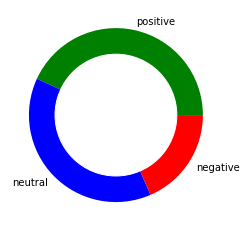

In [23]:
# Creates a pie chart for the percentage of each sentiment type

piechart = count_values_in_column(df , 'sentiment')
names = piechart.index
size = piechart['Percentage']
 
# Creates a circle for the center of the plot

my_circle=plt.Circle((0, 0), 0.7, color= 'white')
plt.pie(size, labels= names, colors= ['green', 'blue', 'red'])
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [24]:
# Creates a function to construct the word cloud

def create_wordcloud(text):
    wc = WordCloud(background_color= 'white', max_words= 2500, repeat= True)
    wc.generate(str(text))
    wc.to_file('wc.png')
    print('Word Cloud Saved Successfully')
    path= 'wc.png'
    display(Image.open(path))

Word Cloud Saved Successfully


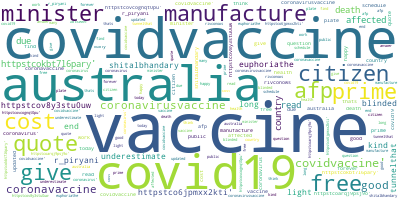

In [25]:
# Display wordcloud of the overall data

create_wordcloud(df['lemmatized'].values)

Word Cloud Saved Successfully


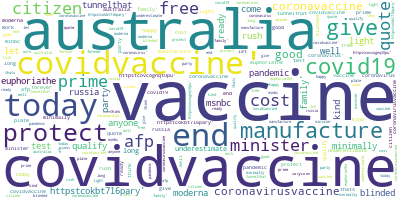

In [26]:
# Display wordcloud of the positive sentiments

create_wordcloud(df_pos['lemmatized'].values)

Word Cloud Saved Successfully


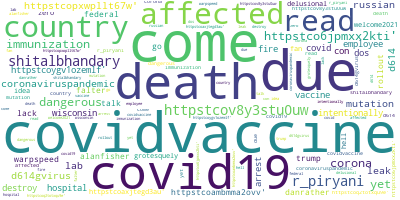

In [27]:
# Display wordcloud of the negative sentiments

create_wordcloud(df_neg['lemmatized'].values)

In [28]:
# Density of tweets

df['text_length'] = df['lemmatized'].apply(len)
df['text_word_count'] = df['lemmatized'].apply(lambda x: len(str(x).split()))
round(pd.DataFrame(df.groupby('sentiment').text_length.mean()), 2)

,text_length
sentiment,
negative,91.47
neutral,87.80
positive,90.72


In [29]:
# Word count for each sentiment type

round(pd.DataFrame(df.groupby('sentiment').text_word_count.mean()), 2)

,text_word_count
sentiment,
negative,11.03
neutral,10.04
positive,10.85


In [30]:
# Apply CountVectorizer to convert each word into a feature

countVectorizer = CountVectorizer() 
countVector = countVectorizer.fit_transform(df['lemmatized'])

In [31]:
count_vect_df = pd.DataFrame(countVector.toarray(), columns=countVectorizer.get_feature_names())
count_vect_df.sample()

,000,001,0013,007,007pandey,01,02,03,032,045,...,𝗳𝗮𝗹𝘀𝗲,𝗴𝗲𝘁,𝗶𝘀,𝗺𝗶𝘀𝗹𝗲𝗮𝗱𝗶𝗻𝗴,𝘃𝗮𝗰𝗰𝗶𝗻𝗮𝘁𝗲𝗱,𝘄𝗵𝗲𝗻,𝘄𝗶𝗹𝗹,𝘆𝗼𝘂,𝘿𝙚𝙠𝙝𝙖,𝙅𝙖𝙮𝙚𝙜𝙖
20158,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
# Finds the most frequently used word

count = pd.DataFrame(count_vect_df.sum())
countdf = count.sort_values(by= 0, ascending= False)
countdf[1:11]

,0
vaccine,11290
covid19,6862
covid,3337
get,2956
first,1551
coronavirus,1502
pfizer,1423
say,1367
trial,1319
news,1158


In [ ]:
# Involve time that tweet was sent